## Linear Regression: Rolling and Recursive

**Functions**

`sm.OLS`, `plt.title`, `plt.legend`, `plt.subplots`, `plt.plot`

### Exercise 35
For the same portfolios in the previous exercise, compute rolling $\beta$s
using 60 consecutive observations.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

ff = pd.read_hdf("data/ff.h5", "ff")
ff.head()

factors = sm.add_constant(ff.iloc[:, :3])
portfolios = ff.iloc[:, 4:]
portfolios = portfolios[["SMALL LoBM", "SMALL HiBM", "BIG LoBM", "BIG HiBM"]]

In [2]:
rolling_betas = {}
rolling_se = {}
nobs = portfolios.shape[0]

for column in portfolios:
    betas = factors.copy()
    betas.loc[:, :] = np.nan
    se = betas.copy()

    portfolio = portfolios[column]
    for i in range(60, nobs):
        y = portfolio.iloc[i - 60 : i]
        x = factors.iloc[i - 60 : i]
        res = sm.OLS(y, x).fit(cov_type="HC0")
        betas.iloc[i] = res.params
        se.iloc[i] = res.bse
    rolling_betas[column] = betas
    rolling_se[column] = se

### Exercise 36

For each of the four $\beta$s, produce a plot containing four series: 

* A line corresponding to the constant $\beta$ (full sample) 
* The $\beta$ estimated on the rolling sample 
* The constant $\beta$ plus $1.96 \times$ the variance of a 60-observation estimate of $\beta$. 
  The 60-month covariance can be estimated using a full sample VCV and rescaling it by T/60 
  where T is the length of the full sample used to estimate the VCV. Alternatively, the VCV
  could be estimated by first estimating the 60-month VCV for each sub-sample and then averaging
  these.
* The constant $\beta$ minus $1.96 \times$ the variance of a 60-observation estimate of $\beta$. 

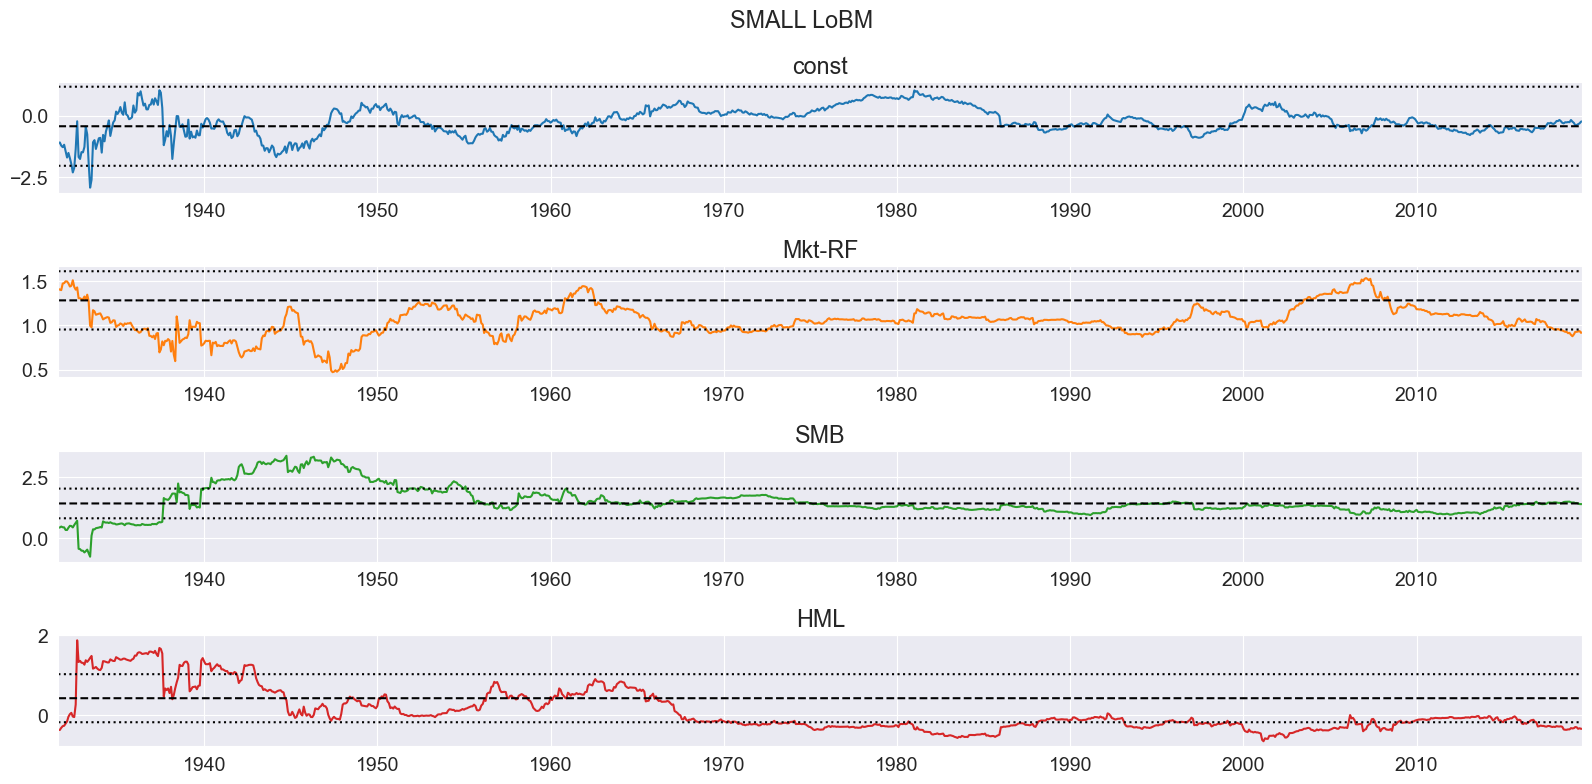

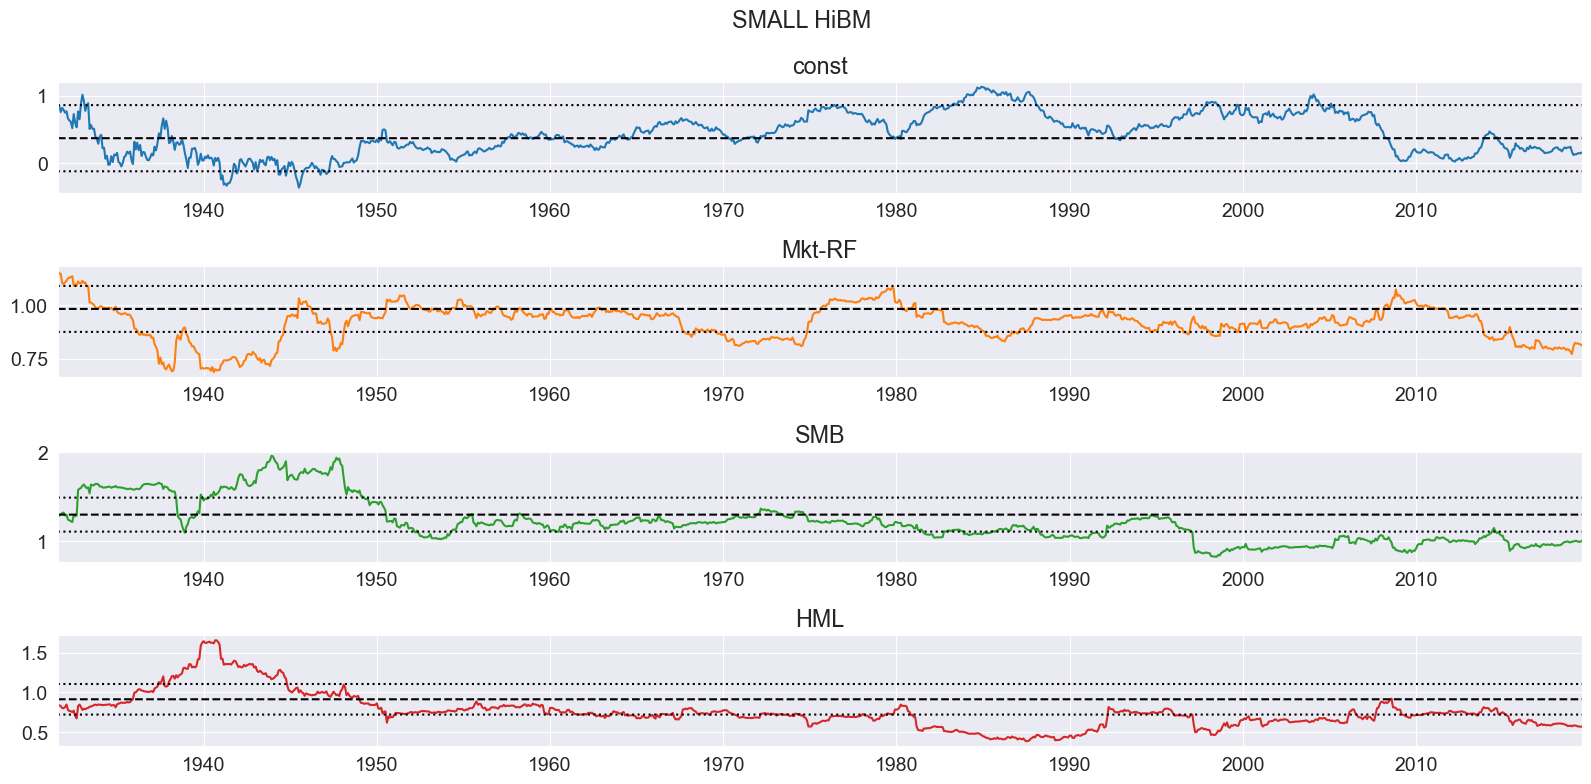

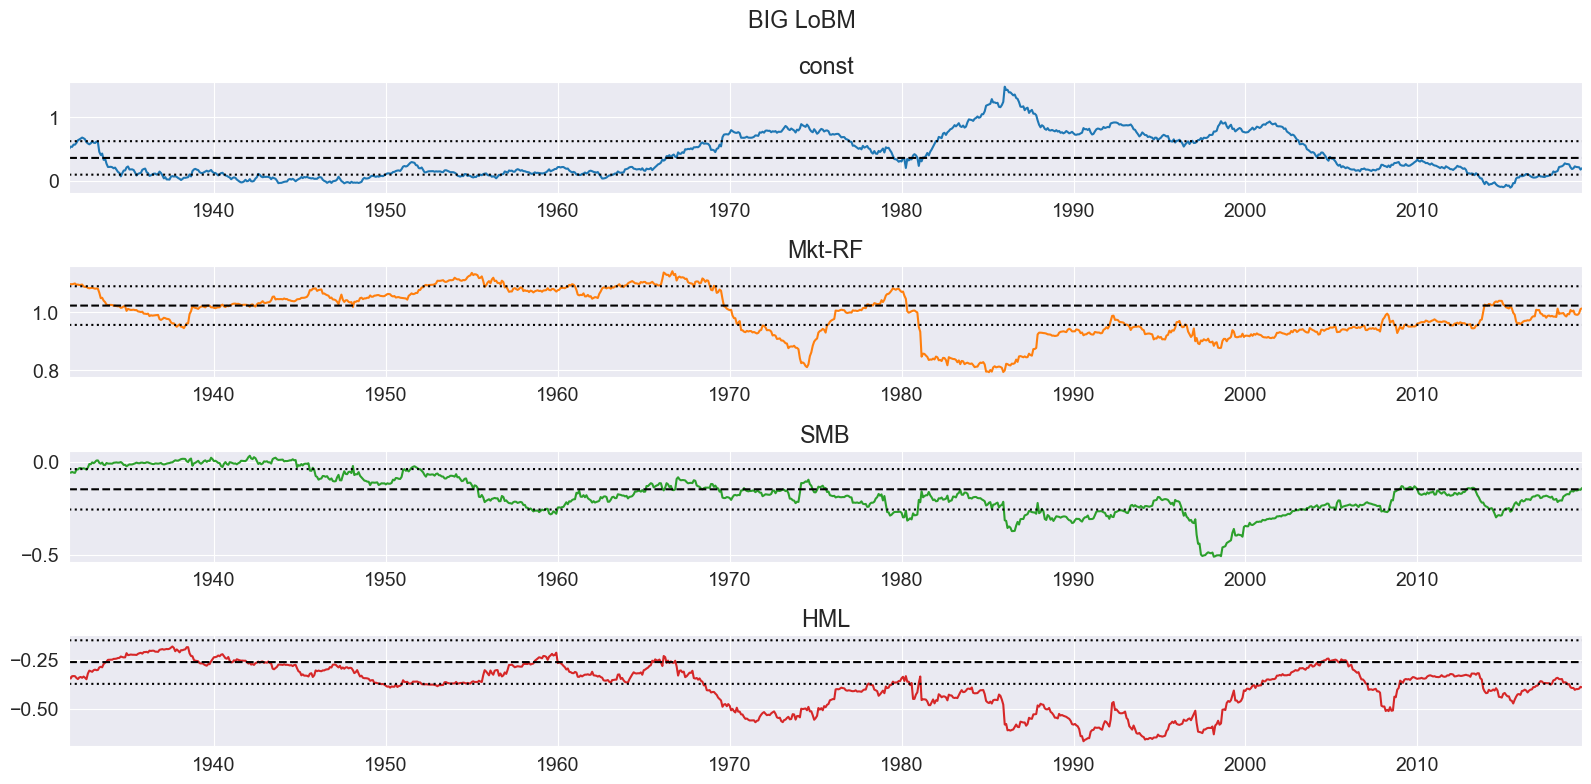

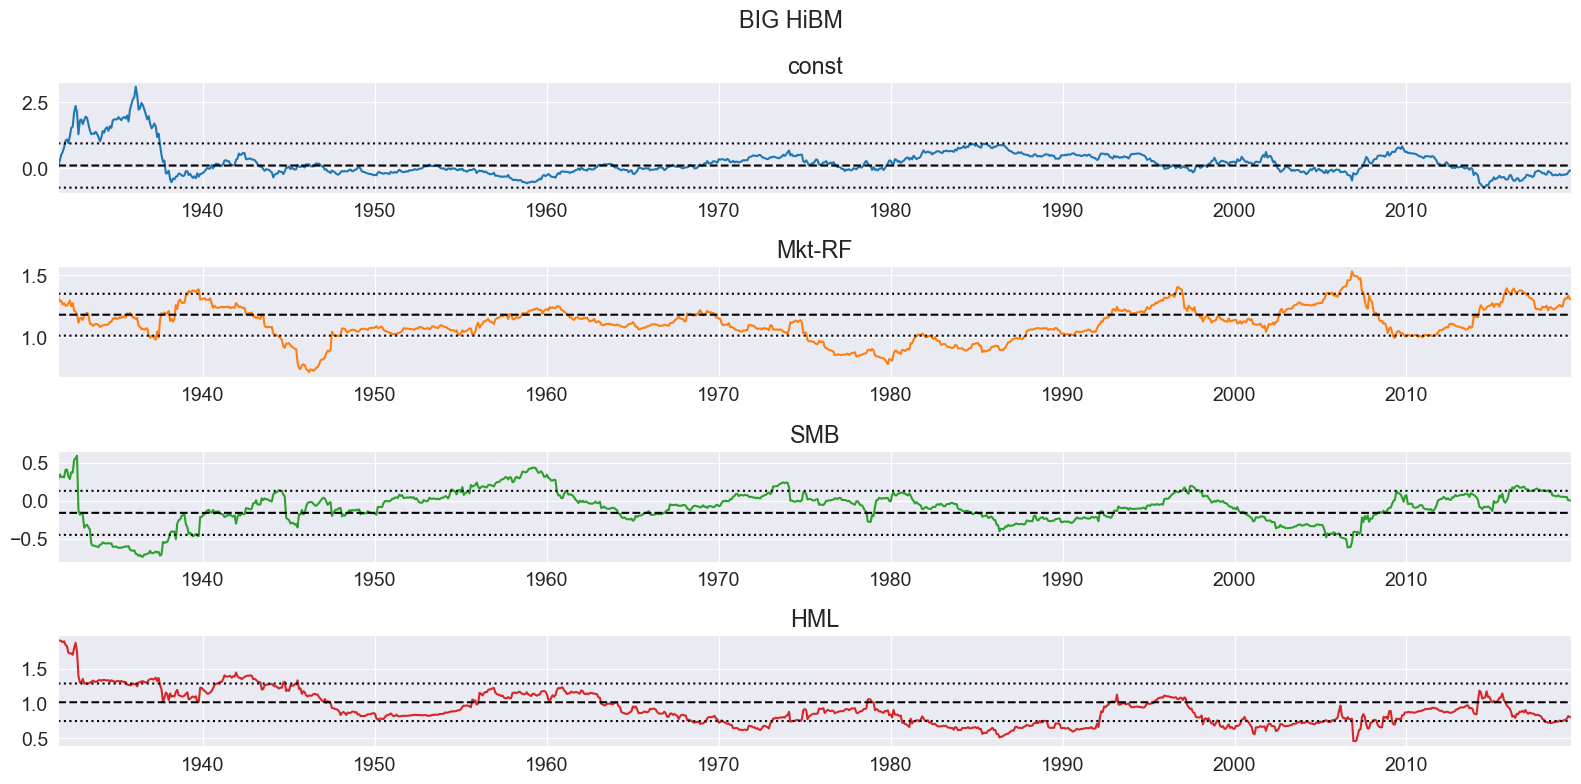

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=14)
sns.set_style("darkgrid")
colors = sns.color_palette()

for column in portfolios:
    betas = rolling_betas[column]
    ses = rolling_se[column]
    variances = ses**2
    const_std_errs = np.sqrt(variances.mean(0))
    full_sample = sm.OLS(portfolios[column], factors).fit()
    fig, axes = plt.subplots(4, 1)
    plt.suptitle(column)
    for i in range(4):
        factor_name = factors.columns[i]
        data = pd.DataFrame({"B": betas.iloc[:, i]})
        const_beta = full_sample.params.iloc[i]
        const_se = const_std_errs.iloc[i]
        data["Constant B"] = const_beta
        data["Upper CI"] = const_beta + 1.96 * const_se
        data["Lower CI"] = const_beta - 1.96 * const_se
        data = data.dropna()

        ax = axes[i]
        ax.plot(data.index, data["B"], color=colors[i])
        ax.plot(data.index, data["Constant B"], linestyle="--", color="black")
        ax.plot(data.index, data["Upper CI"], linestyle=":", color="black")
        ax.plot(data.index, data["Lower CI"], linestyle=":", color="black")
        ax.set_title(factor_name)
        ax.set_xlim(data.index[0], data.index[-1])
    fig.tight_layout(pad=1.0)

### Exercise 37

Do the factor exposures appear constant?

In [4]:
from IPython.display import HTML, display

display(HTML("<b>No</b>"))

### Exercise 38

What happens if only the market is used as a factor (repeat the exercise excluding SMB and HML).

In [5]:
rolling_betas = {}
rolling_se = {}
capm_factors = factors.iloc[:, :2]

for column in portfolios:
    betas = capm_factors.copy()
    betas.loc[:, :] = np.nan
    se = betas.copy()

    portfolio = portfolios[column]
    for i in range(60, nobs):
        y = portfolio.iloc[i - 60 : i]
        x = capm_factors.iloc[i - 60 : i]
        res = sm.OLS(y, x).fit(cov_type="HC0")
        betas.iloc[i] = res.params
        se.iloc[i] = res.bse
    rolling_betas[column] = betas
    rolling_se[column] = se

C:\Users\kevin\AppData\Local\Temp\ipykernel_13176\668653533.py:26: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=1.0)


C:\Users\kevin\AppData\Local\Temp\ipykernel_13176\668653533.py:26: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=1.0)


C:\Users\kevin\AppData\Local\Temp\ipykernel_13176\668653533.py:26: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=1.0)


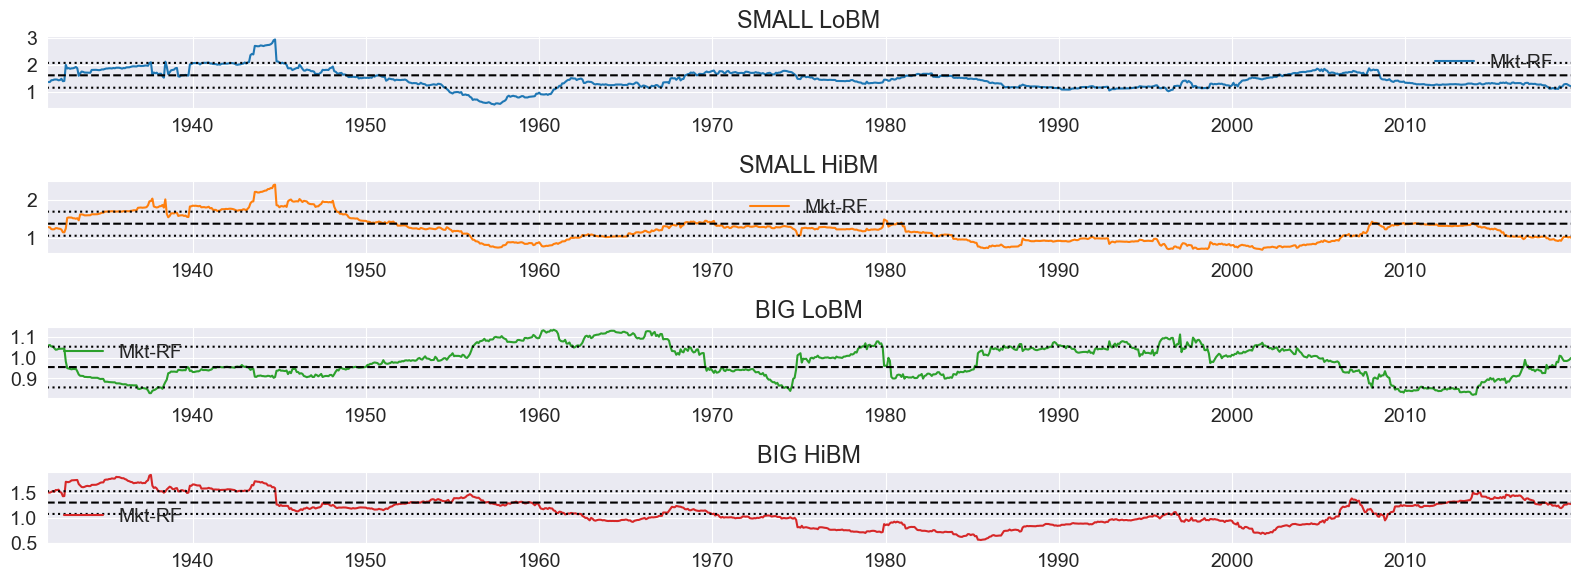

In [6]:
fig, axes = plt.subplots(4, 1, figsize=(16, 6))
for i in range(4):
    column = portfolios.columns[i]
    betas = rolling_betas[column]
    ses = rolling_se[column]
    variances = ses**2
    const_std_errs = np.sqrt(variances.mean(0))
    full_sample = sm.OLS(portfolios[column], capm_factors).fit()

    market_name = "Mkt-RF"
    data = pd.DataFrame({"B": betas[market_name]}).dropna()
    const_beta = full_sample.params[market_name]
    const_se = const_std_errs[market_name]
    data["Constant B"] = const_beta
    data["Upper CI"] = const_beta + 1.96 * const_se
    data["Lower CI"] = const_beta - 1.96 * const_se

    ax = axes[i]
    ax.plot(data.index, data["B"], color=colors[i], label=market_name)
    ax.plot(data.index, data["Constant B"], linestyle="--", color="black")
    ax.plot(data.index, data["Upper CI"], linestyle=":", color="black")
    ax.plot(data.index, data["Lower CI"], linestyle=":", color="black")
    ax.set_title(column)
    ax.set_xlim(data.index[0], data.index[-1])
    ax.legend(frameon=False)
    fig.tight_layout(pad=1.0)

In [7]:
msg = """
With the exception of the the BIG LoBM, all appear to have economically
meaningful time variation.
"""
txt = display(HTML(msg))